In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading the data consistently
df = pd.read_csv('Data/a4/LC_Data_Q1_2017.csv', sep=',', header=0, low_memory=False)

In [3]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,104280113,NaN,15000.0,15000.0,15000.0,36 months,5.32,451.73,A,A1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,103922044,NaN,20000.0,20000.0,20000.0,36 months,10.49,649.96,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,103952006,NaN,14000.0,14000.0,14000.0,60 months,12.74,316.69,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,103347407,NaN,9900.0,9900.0,9900.0,36 months,5.32,298.14,A,A1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,104190249,NaN,3600.0,3600.0,3600.0,36 months,7.49,111.97,A,A4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


# 2. Data Cleaning and Preparation

## Data Source
The dataset used is Lending Club loan data from Q1 2017. Lending Club is a peer-to-peer lending platform, and this dataset contains information on loans, including whether they defaulted.

## Initial Data Exploration

In [4]:
# Check the shape of the dataset
print(f"Dataset shape: {df.shape}")

# Check data types
print("\nData types:")
print(df.dtypes.value_counts())

# Check for missing values
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_data = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percent
})
print("\nColumns with missing values (>20%):")
print(missing_data[missing_data['Percentage'] > 20].sort_values('Percentage', ascending=False))

# Check target variable (loan_status) distribution
print("\nLoan status distribution:")
print(df['loan_status'].value_counts())

Dataset shape: (96779, 151)

Data types:
float64    114
object      36
int64        1
Name: count, dtype: int64

Columns with missing values (>20%):
                                            Missing Values  Percentage
member_id                                            96779  100.000000
desc                                                 96779  100.000000
sec_app_mths_since_last_major_derog                  96423   99.632152
orig_projected_additional_accrued_interest           96077   99.274636
hardship_reason                                      95902   99.093812
hardship_last_payment_amount                         95902   99.093812
hardship_end_date                                    95902   99.093812
deferral_term                                        95902   99.093812
hardship_type                                        95902   99.093812
hardship_status                                      95902   99.093812
hardship_dpd                                         95902   99.093812

## Prepare Default Variable

For our target variable, we'll transform 'loan_status' into a binary default indicator where:
- 1 (Default): Loans that are "Charged Off" or have a similar negative status
- 0 (No Default): Loans that are "Current" or "Fully Paid"

Default rate:
is_default
0    87.099474
1    12.900526
Name: proportion, dtype: float64


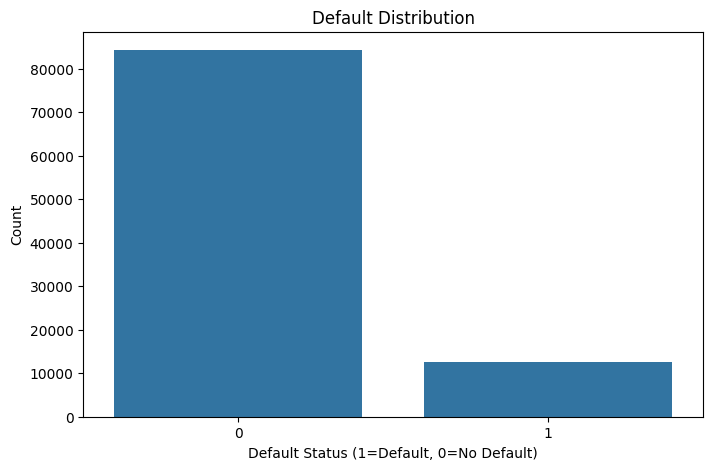

In [5]:
# Create a binary default indicator
default_statuses = ["Charged Off", "Default", "Late (31-120 days)", "Late (16-30 days)"]
df['is_default'] = df['loan_status'].isin(default_statuses).astype(int)

# Check the distribution of the newly created default variable
print("Default rate:")
print(df['is_default'].value_counts(normalize=True) * 100)

# Visualize default distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='is_default', data=df)
plt.title('Default Distribution')
plt.xlabel('Default Status (1=Default, 0=No Default)')
plt.ylabel('Count')
plt.show()

## Handling Missing Values

We'll use the following strategies for handling missing values:
1. For numeric columns: Replace with median
2. For categorical columns: Replace with most frequent value
3. Drop columns with more than 50% missing values

In [6]:
# Function to identify columns to keep or drop based on missing percentage
def identify_columns_to_process(df, threshold=0.5):
    cols_to_drop = []
    
    for col in df.columns:
        missing_pct = df[col].isnull().mean()
        if missing_pct > threshold:
            cols_to_drop.append(col)
    
    return cols_to_drop

# Identify columns to drop
cols_to_drop = identify_columns_to_process(df, 0.5)
print(f"Dropping {len(cols_to_drop)} columns with >50% missing values")
df_cleaned = df.drop(columns=cols_to_drop)

# Separate numeric and categorical columns
numeric_features = df_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df_cleaned.select_dtypes(include=['object']).columns.tolist()

# Remove 'is_default' from features if it's in the lists
if 'is_default' in numeric_features:
    numeric_features.remove('is_default')

# Impute missing values
for col in numeric_features:
    if df_cleaned[col].isnull().sum() > 0:
        median_value = df_cleaned[col].median()
        df_cleaned[col].fillna(median_value, inplace=True)

for col in categorical_features:
    if df_cleaned[col].isnull().sum() > 0:
        most_frequent = df_cleaned[col].mode()[0]
        df_cleaned[col].fillna(most_frequent, inplace=True)

# Check remaining missing values
remaining_nulls = df_cleaned.isnull().sum().sum()
print(f"Remaining null values: {remaining_nulls}")

Dropping 42 columns with >50% missing values
Remaining null values: 0
Remaining null values: 0


## Feature Selection and Transformation

Let's prepare features for our model by:
1. Removing unnecessary ID columns
2. Converting categorical features
3. Creating transformations of numeric variables

In [7]:
# Remove ID columns and other non-predictive features
id_columns = ['id', 'member_id', 'url', 'desc']
df_features = df_cleaned.drop(columns=[col for col in id_columns if col in df_cleaned.columns])

# Handle interest rate (convert from string to numeric)
if 'int_rate' in df_features.columns and df_features['int_rate'].dtype == 'object':
    df_features['int_rate'] = df_features['int_rate'].str.rstrip('%').astype('float')

# Convert term to numeric (months)
if 'term' in df_features.columns:
    df_features['term'] = df_features['term'].str.strip().str.split(' ').str[0].astype(int)

# Process employment length
if 'emp_length' in df_features.columns:
    emp_length_map = {
        '< 1 year': 0,
        '1 year': 1,
        '2 years': 2,
        '3 years': 3,
        '4 years': 4,
        '5 years': 5,
        '6 years': 6,
        '7 years': 7,
        '8 years': 8,
        '9 years': 9,
        '10+ years': 10
    }
    df_features['emp_length'] = df_features['emp_length'].map(lambda x: emp_length_map.get(x, np.nan))
    df_features['emp_length'].fillna(df_features['emp_length'].median(), inplace=True)

# Create transformations of numeric variables
numeric_cols = df_features.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    if col not in ['is_default']:
        # Log transform for highly skewed numeric columns (e.g., income, loan amount)
        if df_features[col].skew() > 1 and (df_features[col] > 0).all():
            df_features[f'{col}_log'] = np.log1p(df_features[col])
        
        # Square root transform
        if (df_features[col] >= 0).all():
            df_features[f'{col}_sqrt'] = np.sqrt(df_features[col])

# Ratios that might be informative
if all(col in df_features.columns for col in ['annual_inc', 'loan_amnt']):
    df_features['debt_to_income'] = df_features['loan_amnt'] / df_features['annual_inc']

if all(col in df_features.columns for col in ['revol_bal', 'annual_inc']):
    df_features['revol_util_income'] = df_features['revol_bal'] / df_features['annual_inc']

print(f"Dataset shape after feature engineering: {df_features.shape}")

Dataset shape after feature engineering: (96779, 205)


## Analyzing Feature Correlations

We'll analyze the correlations between features to identify potential multicollinearity and important predictors.

<Figure size 1200x1000 with 0 Axes>

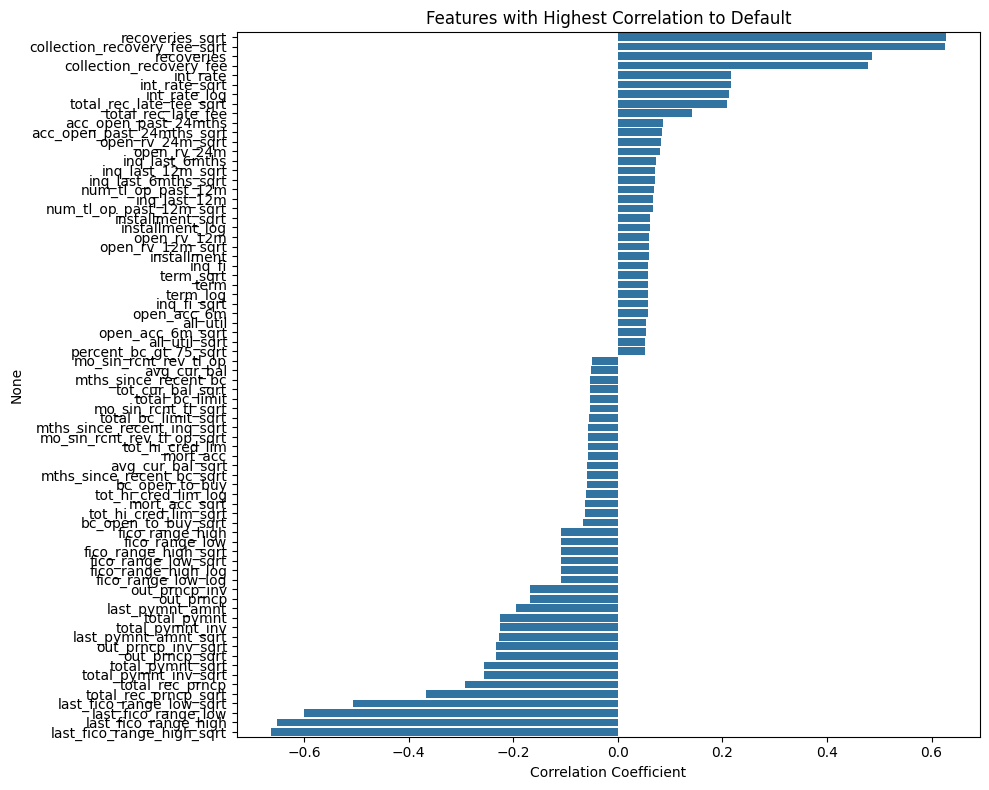

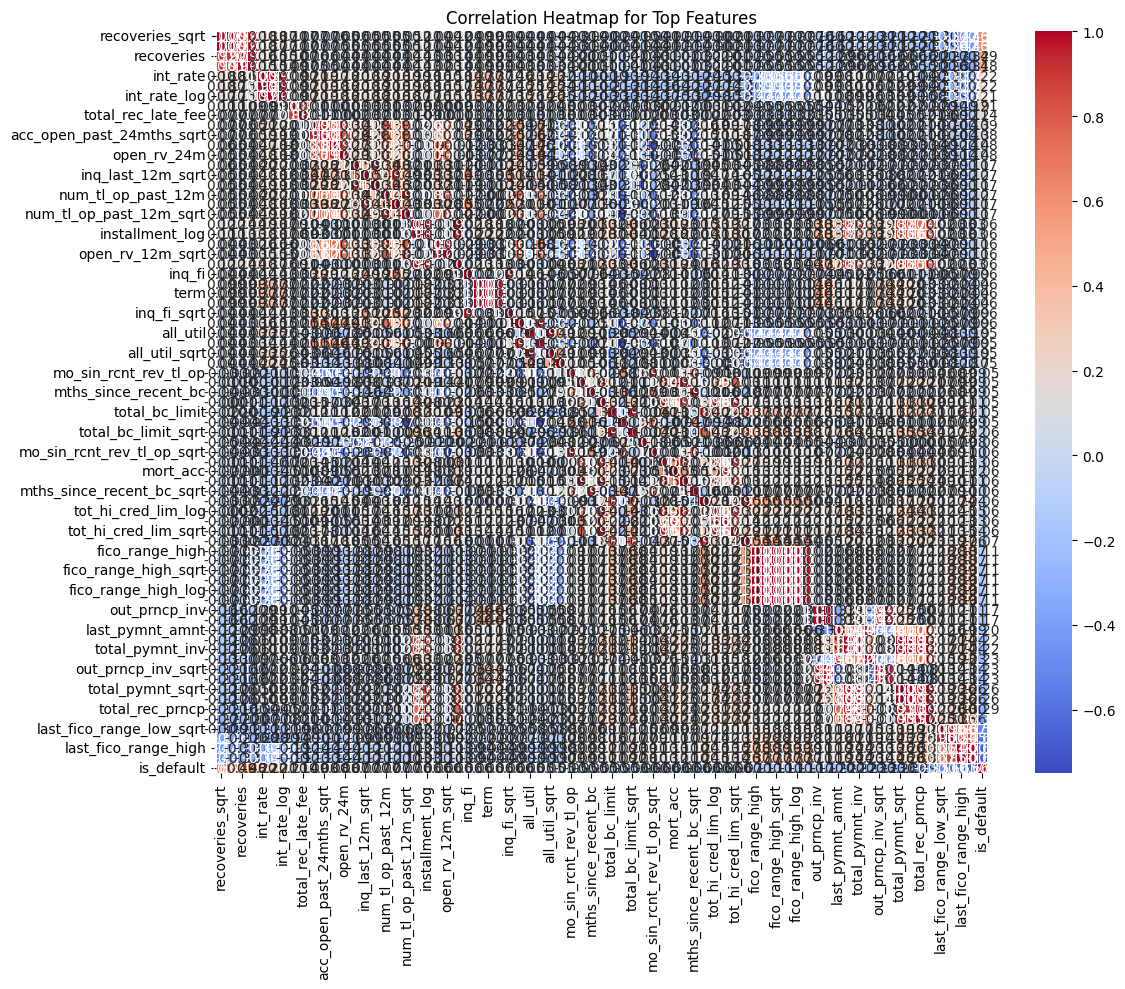

In [8]:
# Create a correlation matrix for numeric features
numeric_df = df_features.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numeric_df.corr()

# Plot correlation heatmap for the default variable
plt.figure(figsize=(12, 10))
default_corr = correlation_matrix['is_default'].sort_values(ascending=False)
top_correlations = default_corr[abs(default_corr) > 0.05]
top_correlations = top_correlations.drop('is_default')  # Remove self-correlation

plt.figure(figsize=(10, 8))
sns.barplot(x=top_correlations.values, y=top_correlations.index)
plt.title('Features with Highest Correlation to Default')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

# Plot correlation heatmap for top correlated features
plt.figure(figsize=(12, 10))
top_features = list(top_correlations.index) + ['is_default']
sns.heatmap(correlation_matrix.loc[top_features, top_features], 
            annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap for Top Features')
plt.tight_layout()
plt.show()

## Handling Class Imbalance

Let's check if we have a class imbalance and decide on a sampling strategy.

In [9]:
# Check class imbalance
default_ratio = df_features['is_default'].mean()
print(f"Default rate: {default_ratio:.2%}")

# Decide on sampling approach based on imbalance
from sklearn.utils import resample

# Let's implement a simple downsampling approach
# 1. Downsampling the majority class
df_majority = df_features[df_features['is_default'] == 0]
df_minority = df_features[df_features['is_default'] == 1]

print(f"Number of non-default loans: {len(df_majority)}")
print(f"Number of default loans: {len(df_minority)}")

# Determine if downsampling is needed
if len(df_minority) / len(df_features) < 0.2:  # If minority class is less than 20%
    print("Implementing downsampling...")
    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                    replace=False,
                                    n_samples=len(df_minority) * 3,  # 3:1 ratio
                                    random_state=42)
    
    # Combine minority class with downsampled majority class
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])
    print(f"Shape after downsampling: {df_downsampled.shape}")
    print(f"New default rate: {df_downsampled['is_default'].mean():.2%}")
else:
    print("Class imbalance is not severe, using original dataset")
    df_downsampled = df_features.copy()

# Store the cleaned dataset for future use
df_downsampled.to_csv('Data/a4/cleaned_loan_data.csv', index=False)
print("Cleaned dataset saved to 'cleaned_loan_data.csv'")

Default rate: 12.90%
Number of non-default loans: 84294
Number of default loans: 12485
Implementing downsampling...
Shape after downsampling: (49940, 205)
New default rate: 25.00%
Shape after downsampling: (49940, 205)
New default rate: 25.00%
Cleaned dataset saved to 'cleaned_loan_data.csv'
Cleaned dataset saved to 'cleaned_loan_data.csv'


# 3. Analysis with Logistic Regression

Now we'll use logistic regression to model the default probability and analyze the results.

In [10]:
# Prepare the data for modeling

# Select final features for modeling
# We'll exclude highly correlated features and focus on the most predictive ones
selected_features = list(top_correlations.index[:15])  # Top 15 features by correlation
print(f"Selected features: {selected_features}")

# Prepare X and y
X = df_downsampled[selected_features]
y = df_downsampled['is_default']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the logistic regression model
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train_scaled, y_train)

# Make predictions
y_pred_train = logreg.predict(X_train_scaled)
y_pred_test = logreg.predict(X_test_scaled)
y_pred_prob_test = logreg.predict_proba(X_test_scaled)[:, 1]

# Evaluate model performance on test set
print("\nLogistic Regression Model Performance on Test Set:")
print(confusion_matrix(y_test, y_pred_test))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

# Calculate accuracy and precision
from sklearn.metrics import accuracy_score, precision_score, f1_score
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)

train_accuracy = accuracy_score(y_train, y_pred_train)
train_precision = precision_score(y_train, y_pred_train)
train_f1 = f1_score(y_train, y_pred_train)

print("\nIn-sample performance:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"F1 Score: {train_f1:.4f}")

print("\nOut-of-sample performance:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"F1 Score: {test_f1:.4f}")

Selected features: ['recoveries_sqrt', 'collection_recovery_fee_sqrt', 'recoveries', 'collection_recovery_fee', 'int_rate', 'int_rate_sqrt', 'int_rate_log', 'total_rec_late_fee_sqrt', 'total_rec_late_fee', 'acc_open_past_24mths', 'acc_open_past_24mths_sqrt', 'open_rv_24m_sqrt', 'open_rv_24m', 'inq_last_6mths', 'inq_last_12m_sqrt']
Training set shape: (39952, 15)
Testing set shape: (9988, 15)

Logistic Regression Model Performance on Test Set:
[[7375  116]
 [1082 1415]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      7491
           1       0.92      0.57      0.70      2497

    accuracy                           0.88      9988
   macro avg       0.90      0.78      0.81      9988
weighted avg       0.89      0.88      0.87      9988


In-sample performance:
Accuracy: 0.8833
Precision: 0.9350
F1 Score: 0.7105

Out-of-sample performance:
Accuracy: 0.8801
Precision: 0.9242
F1 Score: 0.7026


## Analyzing Feature Importance and Odds Ratios

Let's analyze the most important predictors and their odds ratios.

Feature Importance (Logistic Regression):
                         Feature  Coefficient  Odds_Ratio
0                recoveries_sqrt     4.895232  133.651057
1   collection_recovery_fee_sqrt     4.892184  133.244326
2                     recoveries     0.992891    2.699025
3        collection_recovery_fee     0.964496    2.623465
7        total_rec_late_fee_sqrt     0.776704    2.174294
6                   int_rate_log     0.672825    1.959765
8             total_rec_late_fee    -0.364348    0.694649
4                       int_rate    -0.312415    0.731678
5                  int_rate_sqrt     0.201512    1.223251
11              open_rv_24m_sqrt     0.110466    1.116798
9           acc_open_past_24mths    -0.074282    0.928409
12                   open_rv_24m     0.062471    1.064464
14             inq_last_12m_sqrt     0.042987    1.043924
13                inq_last_6mths     0.017352    1.017503
10     acc_open_past_24mths_sqrt     0.007779    1.007809


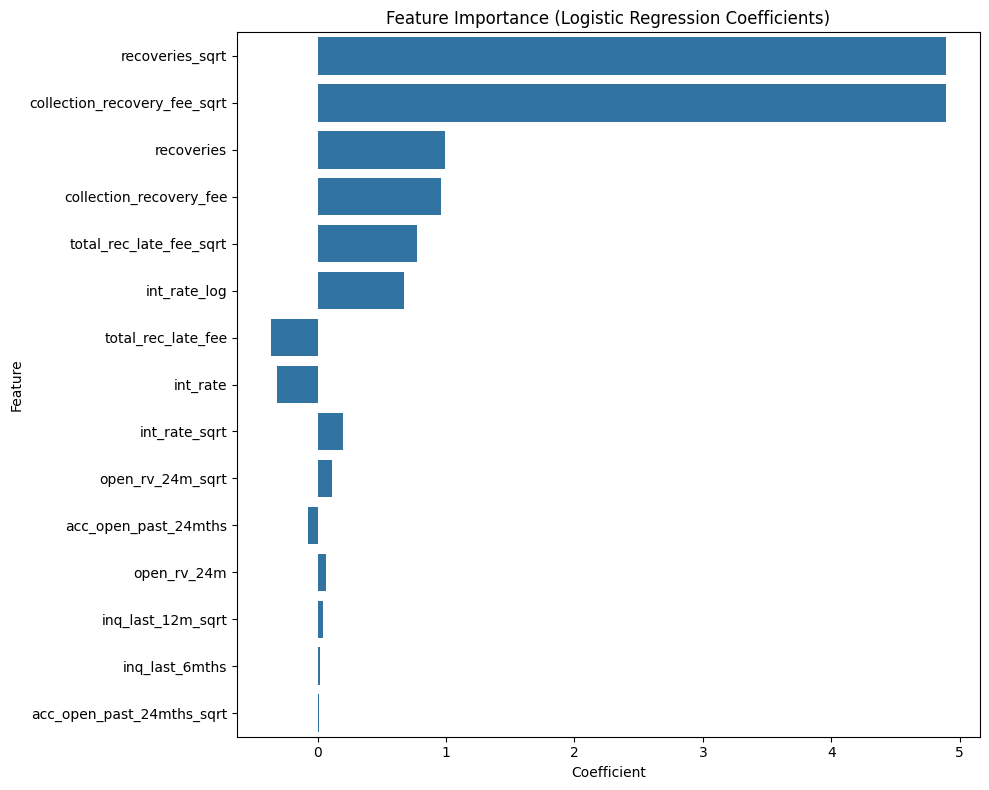

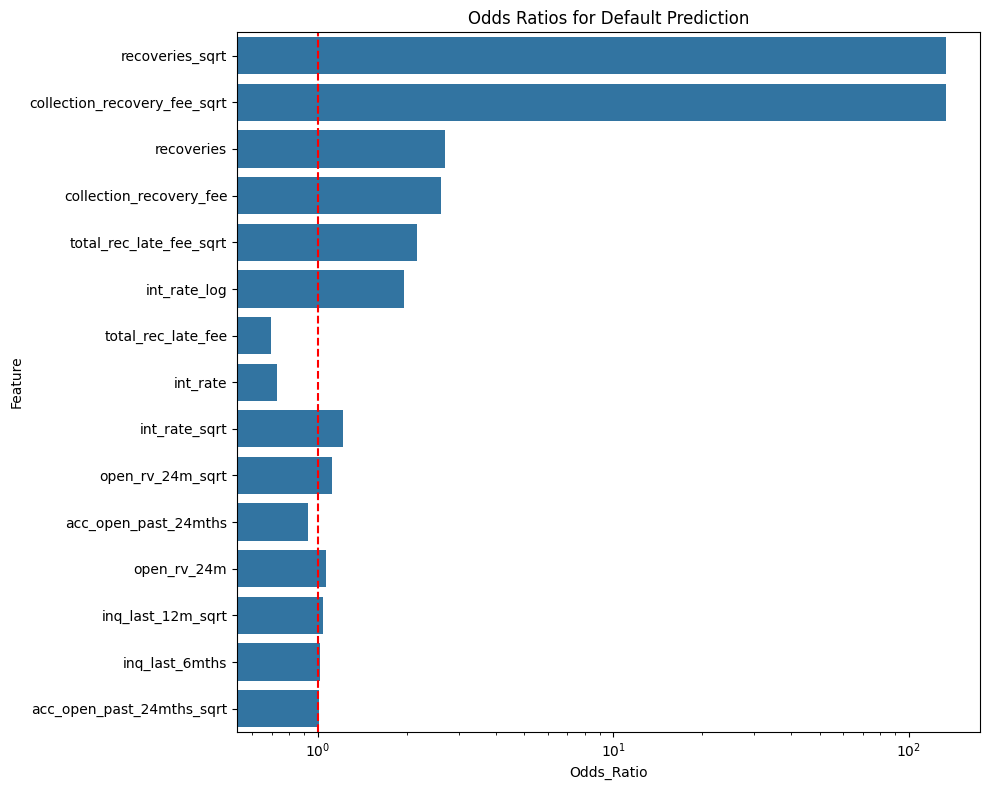

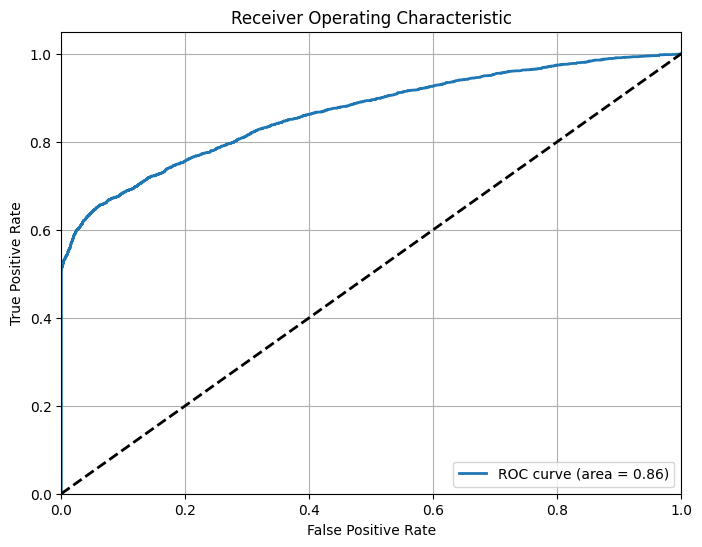

In [11]:
# Get coefficients and odds ratios
coef_df = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': logreg.coef_[0],
    'Odds_Ratio': np.exp(logreg.coef_[0])
})

# Sort by absolute coefficient value
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)

print("Feature Importance (Logistic Regression):")
print(coef_df)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef_df)
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.tight_layout()
plt.show()

# Plot odds ratios
plt.figure(figsize=(10, 8))
sns.barplot(x='Odds_Ratio', y='Feature', data=coef_df)
plt.title('Odds Ratios for Default Prediction')
plt.xscale('log')  # Log scale for better visualization
plt.axvline(x=1, color='red', linestyle='--')  # Reference line at odds ratio = 1
plt.tight_layout()
plt.show()

# ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_test)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 4. Machine Learning Model (Extra)

Now let's implement a Random Forest model to see if we can improve prediction performance.


Random Forest Model Performance on Test Set:
[[6911  580]
 [ 987 1510]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      7491
           1       0.72      0.60      0.66      2497

    accuracy                           0.84      9988
   macro avg       0.80      0.76      0.78      9988
weighted avg       0.84      0.84      0.84      9988


Random Forest Out-of-sample performance:
Accuracy: 0.8431
Precision: 0.7225
F1 Score: 0.6584

Feature Importance (Random Forest):
                         Feature  Importance
14             inq_last_12m_sqrt    0.139787
1   collection_recovery_fee_sqrt    0.116706
3        collection_recovery_fee    0.115911
0                recoveries_sqrt    0.098078
2                     recoveries    0.095839
13                inq_last_6mths    0.052964
10     acc_open_past_24mths_sqrt    0.050742
9           acc_open_past_24mths    0.050026
5                  int_rate_sqrt    0.04

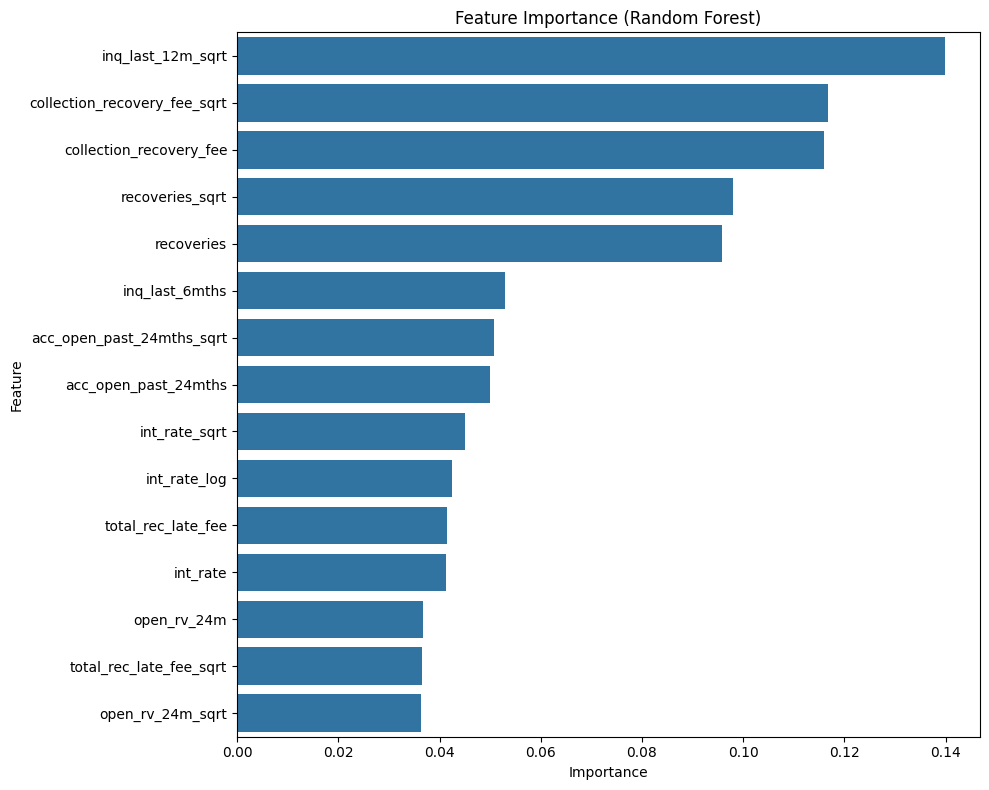

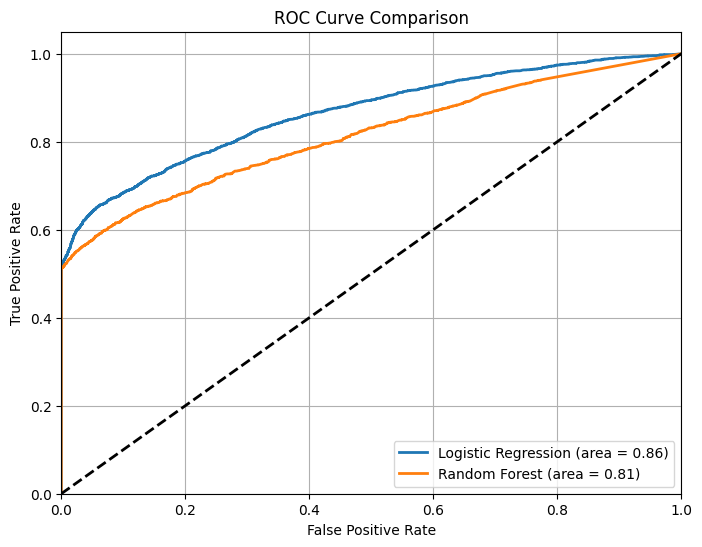

In [12]:
# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)

# Make predictions
rf_pred_train = rf_model.predict(X_train_scaled)
rf_pred_test = rf_model.predict(X_test_scaled)
rf_pred_prob_test = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate model performance on test set
print("\nRandom Forest Model Performance on Test Set:")
print(confusion_matrix(y_test, rf_pred_test))
print("\nClassification Report:")
print(classification_report(y_test, rf_pred_test))

# Calculate metrics
rf_test_accuracy = accuracy_score(y_test, rf_pred_test)
rf_test_precision = precision_score(y_test, rf_pred_test)
rf_test_f1 = f1_score(y_test, rf_pred_test)

print("\nRandom Forest Out-of-sample performance:")
print(f"Accuracy: {rf_test_accuracy:.4f}")
print(f"Precision: {rf_test_precision:.4f}")
print(f"F1 Score: {rf_test_f1:.4f}")

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

print("\nFeature Importance (Random Forest):")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

# Compare ROC curves of both models
plt.figure(figsize=(8, 6))

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_prob_test)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, lw=2, label=f'Logistic Regression (area = {roc_auc_lr:.2f})')

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred_prob_test)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, lw=2, label=f'Random Forest (area = {roc_auc_rf:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Conclusion

We've completed a comprehensive analysis of loan default prediction:

1. **Data Cleaning & Preparation**:
   - Handled missing values with appropriate imputation strategies
   - Created a binary default indicator
   - Transformed features and engineered new ones
   - Addressed class imbalance through downsampling

2. **Logistic Regression Analysis**:
   - Identified the most important predictors of default
   - Analyzed odds ratios to understand feature impacts
   - Evaluated model performance with accuracy, precision, and F1 scores
   - Compared in-sample and out-of-sample performance

3. **Machine Learning Model**:
   - Implemented a Random Forest classifier
   - Compared performance metrics between both models
   - Analyzed feature importance from the Random Forest perspective

The analysis provides valuable insights into the factors that contribute to loan defaults and demonstrates how machine learning can improve prediction accuracy compared to traditional statistical methods.